# Climate Data Scraping: Locate Climate Data
#### Fire Atlas Dataset + NCDC GSOM + NCDC Monthly Normals

Andrew McDonald // CSE 847 // April 2021

In [175]:
import requests
import urllib
import json
from datetime import datetime

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 25)

In [3]:
ignitions = pd.read_csv("data/2016_wildfires.csv")
ignitions

,fire_ID,latitude,longitude,size,perimeter,start_date,start_DOY,end_date,end_DOY,duration,expansion,fire_line,speed,direction,direction_s,landcover,landcover_s,tile_ID
0,1,20.8438,-156.4130,0.86,4.63,2016-10-26,300,2016-11-02,307,8,0.11,0.23,0.37,3,east,12,Croplands,h03v06
1,2,20.8396,-156.4180,1.50,6.48,2016-10-28,302,2016-11-02,307,6,0.25,0.54,0.57,4,southeast,12,Croplands,h03v06
2,3,20.8105,-156.4370,0.43,2.78,2016-11-29,334,2016-11-29,334,1,0.43,0.93,0.46,0,none,12,Croplands,h03v06
3,4,20.6271,-156.2470,18.65,30.56,2016-02-16,47,2016-02-20,51,5,3.73,6.20,2.68,8,northwest,7,Open shrublands,h03v06
4,5,19.8063,-155.8950,7.72,12.96,2016-03-20,80,2016-03-25,85,6,1.29,2.47,1.39,4,southeast,7,Open shrublands,h03v07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887216,887217,-15.2604,145.1189,1.50,6.48,2016-11-21,326,2016-11-23,328,3,0.50,1.08,0.91,3,east,8,Woody savannas,h32v10
887217,887218,-15.2770,145.1347,0.64,3.70,2016-11-17,322,2016-11-21,326,5,0.13,0.28,0.51,5,south,8,Woody savannas,h32v10
887218,887219,-15.3104,145.1535,2.57,7.41,2016-10-21,295,2016-10-30,304,10,0.26,0.56,0.97,3,east,8,Woody savannas,h32v10
887219,887220,-15.3020,145.1779,1.50,5.56,2016-10-02,276,2016-10-08,282,7,0.21,0.46,0.75,8,northwest,8,Woody savannas,h32v10


## 1. Explore Datasets

In [12]:
api_token = "syKpWfFaNGhSsksXrJhcrwQspIYihUqW"
base_url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/"
headers = {"token": api_token}
resource = "datasets"
endpoint = base_url + resource
response = requests.get(endpoint, headers=headers)
print(response)

datasets = json.loads(response.text)
pd.DataFrame(datasets["results"])

<Response [200]>


,uid,mindate,maxdate,name,datacoverage,id
0,gov.noaa.ncdc:C00861,1763-01-01,2021-04-19,Daily Summaries,1.00,GHCND
1,gov.noaa.ncdc:C00946,1763-01-01,2021-04-01,Global Summary of the Month,1.00,GSOM
2,gov.noaa.ncdc:C00947,1763-01-01,2021-01-01,Global Summary of the Year,1.00,GSOY
3,gov.noaa.ncdc:C00345,1991-06-05,2021-04-20,Weather Radar (Level II),0.95,NEXRAD2
4,gov.noaa.ncdc:C00708,1994-05-20,2021-04-19,Weather Radar (Level III),0.95,NEXRAD3
5,gov.noaa.ncdc:C00821,2010-01-01,2010-01-01,Normals Annual/Seasonal,1.00,NORMAL_ANN
6,gov.noaa.ncdc:C00823,2010-01-01,2010-12-31,Normals Daily,1.00,NORMAL_DLY
7,gov.noaa.ncdc:C00824,2010-01-01,2010-12-31,Normals Hourly,1.00,NORMAL_HLY
8,gov.noaa.ncdc:C00822,2010-01-01,2010-12-01,Normals Monthly,1.00,NORMAL_MLY
9,gov.noaa.ncdc:C00505,1970-05-12,2014-01-01,Precipitation 15 Minute,0.25,PRECIP_15


## 2. Explore Datatypes in Datasets

In [15]:
# explore monthly summaries
resource = "datatypes?"
query = {
    "datasetid": "GSOM",
    "startdate": "2016-01-01",
    "enddate": "2016-01-01",
    "limit": "1000"
}
query_str = urllib.parse.urlencode(query, doseq=False)
endpoint = base_url + resource + query_str
response = requests.get(endpoint, headers=headers)
print(response)

datatypes_gsom = pd.DataFrame(json.loads(response.text)["results"])
datatypes_gsom

<Response [200]>


,mindate,maxdate,name,datacoverage,id
0,1982-01-01,2021-03-01,Average wind speed,1.0,AWND
1,1763-01-01,2021-03-01,Cooling Degree Days Season to Date,1.0,CDSD
2,1763-01-01,2021-03-01,Cooling Degree Days,1.0,CLDD
3,1781-01-01,2021-03-01,Number of days with greater than or equal to 0...,1.0,DP01
4,1781-01-01,2021-03-01,Number of days with greater than or equal to 1...,1.0,DP10
...,...,...,...,...,...
84,1948-01-01,2021-03-01,Direction of peak wind gust,1.0,WDFG
85,1859-10-01,2021-02-01,Total wind movement,1.0,WDMV
86,1993-06-01,2021-03-01,Fastest 2-minute wind speed,1.0,WSF2
87,1993-06-01,2021-03-01,Fastest 5-second wind speed,1.0,WSF5


In [23]:
# explore daily summaries
query["datasetid"] = "GHCND"
query_str = urllib.parse.urlencode(query, doseq=False)
endpoint = base_url + resource + query_str
response = requests.get(endpoint, headers=headers)
print(response)

datatypes_ghcnd = pd.DataFrame(json.loads(response.text)["results"])
datatypes_ghcnd

<Response [200]>


,mindate,maxdate,name,datacoverage,id
0,1982-01-01,2021-04-18,Average wind speed,1.0,AWND
1,1948-08-02,2012-07-23,Number of days included in the multiday evapor...,1.0,DAEV
2,1832-05-11,2021-04-19,Number of days included in the multiday precip...,1.0,DAPR
3,1877-01-02,2020-11-30,Number of days included in the multiday snow f...,1.0,DASF
4,1863-05-04,2021-04-19,Number of days included in the multiday minimu...,1.0,DATN
...,...,...,...,...,...
93,1982-01-18,2017-03-26,Freezing rain,1.0,WT17
94,1851-04-13,2020-10-04,"Snow, snow pellets, snow grains, or ice crystals",1.0,WT18
95,1992-11-01,2013-03-31,Unknown source of precipitation,1.0,WT19
96,1996-07-01,2013-03-31,Ground fog,1.0,WT21


In [28]:
# explore monthly normals
query.update((("startdate", "2010-01-01"),
              ("enddate", "2010-12-31"),
              ("datasetid", "NORMAL_MLY")))
query_str = urllib.parse.urlencode(query, doseq=False)
endpoint = base_url + resource + query_str
response = requests.get(endpoint, headers=headers)
print(response)

datatypes_normal_mly = pd.DataFrame(json.loads(response.text)["results"])
datatypes_normal_mly


<Response [200]>


,mindate,maxdate,name,datacoverage,id
0,2010-01-01,2010-12-01,Long-term averages of monthly cooling degree d...,1,MLY-CLDD-BASE45
1,2010-01-01,2010-12-01,Long-term averages of monthly cooling degree d...,1,MLY-CLDD-BASE50
2,2010-01-01,2010-12-01,Long-term averages of monthly cooling degree d...,1,MLY-CLDD-BASE55
3,2010-01-01,2010-12-01,Long-term averages of monthly cooling degree d...,1,MLY-CLDD-BASE57
4,2010-01-01,2010-12-01,Long-term averages of monthly cooling degree d...,1,MLY-CLDD-BASE60
...,...,...,...,...,...
72,2010-01-01,2010-12-01,probability of 24F or below at least once in t...,1,MLY-TMIN-PRBOCC-LSTH024
73,2010-01-01,2010-12-01,probability of 28F or below at least once in t...,1,MLY-TMIN-PRBOCC-LSTH028
74,2010-01-01,2010-12-01,probability of 32F or below at least once in t...,1,MLY-TMIN-PRBOCC-LSTH032
75,2010-01-01,2010-12-01,probability of 36F or below at least once in t...,1,MLY-TMIN-PRBOCC-LSTH036


In [29]:
# explore daily normals
query["datasetid"] = "NORMAL_DLY"
query_str = urllib.parse.urlencode(query, doseq=False)
endpoint = base_url + resource + query_str
response = requests.get(endpoint, headers=headers)
print(response)

datatypes_normal_dly = pd.DataFrame(json.loads(response.text)["results"])
datatypes_normal_dly

<Response [200]>


,mindate,maxdate,name,datacoverage,id
0,2010-01-01,2010-12-31,Long-term averages of daily cooling degree day...,1,DLY-CLDD-BASE45
1,2010-01-01,2010-12-31,Long-term averages of daily cooling degree day...,1,DLY-CLDD-BASE50
2,2010-01-01,2010-12-31,Long-term averages of daily cooling degree day...,1,DLY-CLDD-BASE55
3,2010-01-01,2010-12-31,Long-term averages of daily cooling degree day...,1,DLY-CLDD-BASE57
4,2010-01-01,2010-12-31,Long-term averages of daily cooling degree day...,1,DLY-CLDD-BASE60
...,...,...,...,...,...
55,2010-01-01,2010-12-31,Long-term standard deviations of daily minimum...,1,DLY-TMIN-STDDEV
56,2010-01-01,2010-12-31,Long-term average month-to-date precipitation ...,1,MTD-PRCP-NORMAL
57,2010-01-01,2010-12-31,Long-term average month-to-date snowfall totals,1,MTD-SNOW-NORMAL
58,2010-01-01,2010-12-31,Long-term average year-to-date precipitation t...,1,YTD-PRCP-NORMAL


In [122]:
# save all datatypes
datatypes_gsom["dataset"] = "GSOM"
datatypes_ghcnd["dataset"] = "GHCND"
datatypes_normal_mly["dataset"] = "NORMAL_MLY"
datatypes_normal_dly["dataset"] = "NORMAL_DLY"
all_datatypes = pd.concat((datatypes_gsom, datatypes_ghcnd,
                           datatypes_normal_mly, datatypes_normal_dly))
all_datatypes = all_datatypes[["dataset", "id"] + list(all_datatypes.columns)[:-2]]
all_datatypes = all_datatypes.reset_index(drop=True)
all_datatypes.to_csv("data/ncdc_datatypes.csv", index=False)
all_datatypes

,dataset,id,mindate,maxdate,name,datacoverage
0,GSOM,AWND,1982-01-01,2021-03-01,Average wind speed,1.0
1,GSOM,CDSD,1763-01-01,2021-03-01,Cooling Degree Days Season to Date,1.0
2,GSOM,CLDD,1763-01-01,2021-03-01,Cooling Degree Days,1.0
3,GSOM,DP01,1781-01-01,2021-03-01,Number of days with greater than or equal to 0...,1.0
4,GSOM,DP10,1781-01-01,2021-03-01,Number of days with greater than or equal to 1...,1.0
...,...,...,...,...,...,...
319,NORMAL_DLY,DLY-TMIN-STDDEV,2010-01-01,2010-12-31,Long-term standard deviations of daily minimum...,1.0
320,NORMAL_DLY,MTD-PRCP-NORMAL,2010-01-01,2010-12-31,Long-term average month-to-date precipitation ...,1.0
321,NORMAL_DLY,MTD-SNOW-NORMAL,2010-01-01,2010-12-31,Long-term average month-to-date snowfall totals,1.0
322,NORMAL_DLY,YTD-PRCP-NORMAL,2010-01-01,2010-12-31,Long-term average year-to-date precipitation t...,1.0


In [123]:
# save monthly datatypes
monthly_vars = all_datatypes[(all_datatypes["dataset"] == "GSOM") | (all_datatypes["dataset"] == "NORMAL_MLY")]
monthly_vars = monthly_vars.reset_index(drop=True)
monthly_vars.to_csv("data/ncdc_monthly_datatypes.csv", index=False)
monthly_vars

,dataset,id,mindate,maxdate,name,datacoverage
0,GSOM,AWND,1982-01-01,2021-03-01,Average wind speed,1.0
1,GSOM,CDSD,1763-01-01,2021-03-01,Cooling Degree Days Season to Date,1.0
2,GSOM,CLDD,1763-01-01,2021-03-01,Cooling Degree Days,1.0
3,GSOM,DP01,1781-01-01,2021-03-01,Number of days with greater than or equal to 0...,1.0
4,GSOM,DP10,1781-01-01,2021-03-01,Number of days with greater than or equal to 1...,1.0
...,...,...,...,...,...,...
161,NORMAL_MLY,MLY-TMIN-PRBOCC-LSTH024,2010-01-01,2010-12-01,probability of 24F or below at least once in t...,1.0
162,NORMAL_MLY,MLY-TMIN-PRBOCC-LSTH028,2010-01-01,2010-12-01,probability of 28F or below at least once in t...,1.0
163,NORMAL_MLY,MLY-TMIN-PRBOCC-LSTH032,2010-01-01,2010-12-01,probability of 32F or below at least once in t...,1.0
164,NORMAL_MLY,MLY-TMIN-PRBOCC-LSTH036,2010-01-01,2010-12-01,probability of 36F or below at least once in t...,1.0


## 2. Explore Stations

In [124]:
# get number of stations with each variable in their observation set
resource = "stations?"
monthly_vars["station_count"] = 0

for i, row in monthly_vars.iterrows():
    query = {
        "datasetid": row["dataset"],
        "datatypeid": row["id"],
        "startdate": "2010-01-01" if "NORMAL" in row["dataset"] else "2016-01-01",
        "enddate": "2010-12-31" if "NORMAL" in row["dataset"] else "2016-12-31",
    }
    query_str = urllib.parse.urlencode(query, doseq=False)
    endpoint = base_url + resource + query_str
    response = requests.get(endpoint, headers=headers)
    d = json.loads(response.text)
    if "metadata" in d:
        monthly_vars.iloc[i, -1] = d["metadata"]["resultset"]["count"]
    else:
        print(f"No data found for {row['dataset']}, {row['id']}.")
    if i % 50 == 0:
        print(f"Queried {i} variables.")

monthly_vars

Queried 0 variables.
Queried 50 variables.
Queried 100 variables.
Queried 150 variables.


,dataset,id,mindate,maxdate,name,datacoverage,station_count
0,GSOM,AWND,1982-01-01,2021-03-01,Average wind speed,1.0,1041
1,GSOM,CDSD,1763-01-01,2021-03-01,Cooling Degree Days Season to Date,1.0,12490
2,GSOM,CLDD,1763-01-01,2021-03-01,Cooling Degree Days,1.0,14687
3,GSOM,DP01,1781-01-01,2021-03-01,Number of days with greater than or equal to 0...,1.0,35454
4,GSOM,DP10,1781-01-01,2021-03-01,Number of days with greater than or equal to 1...,1.0,35454
...,...,...,...,...,...,...,...
161,NORMAL_MLY,MLY-TMIN-PRBOCC-LSTH024,2010-01-01,2010-12-01,probability of 24F or below at least once in t...,1.0,5805
162,NORMAL_MLY,MLY-TMIN-PRBOCC-LSTH028,2010-01-01,2010-12-01,probability of 28F or below at least once in t...,1.0,5805
163,NORMAL_MLY,MLY-TMIN-PRBOCC-LSTH032,2010-01-01,2010-12-01,probability of 32F or below at least once in t...,1.0,5805
164,NORMAL_MLY,MLY-TMIN-PRBOCC-LSTH036,2010-01-01,2010-12-01,probability of 36F or below at least once in t...,1.0,5805


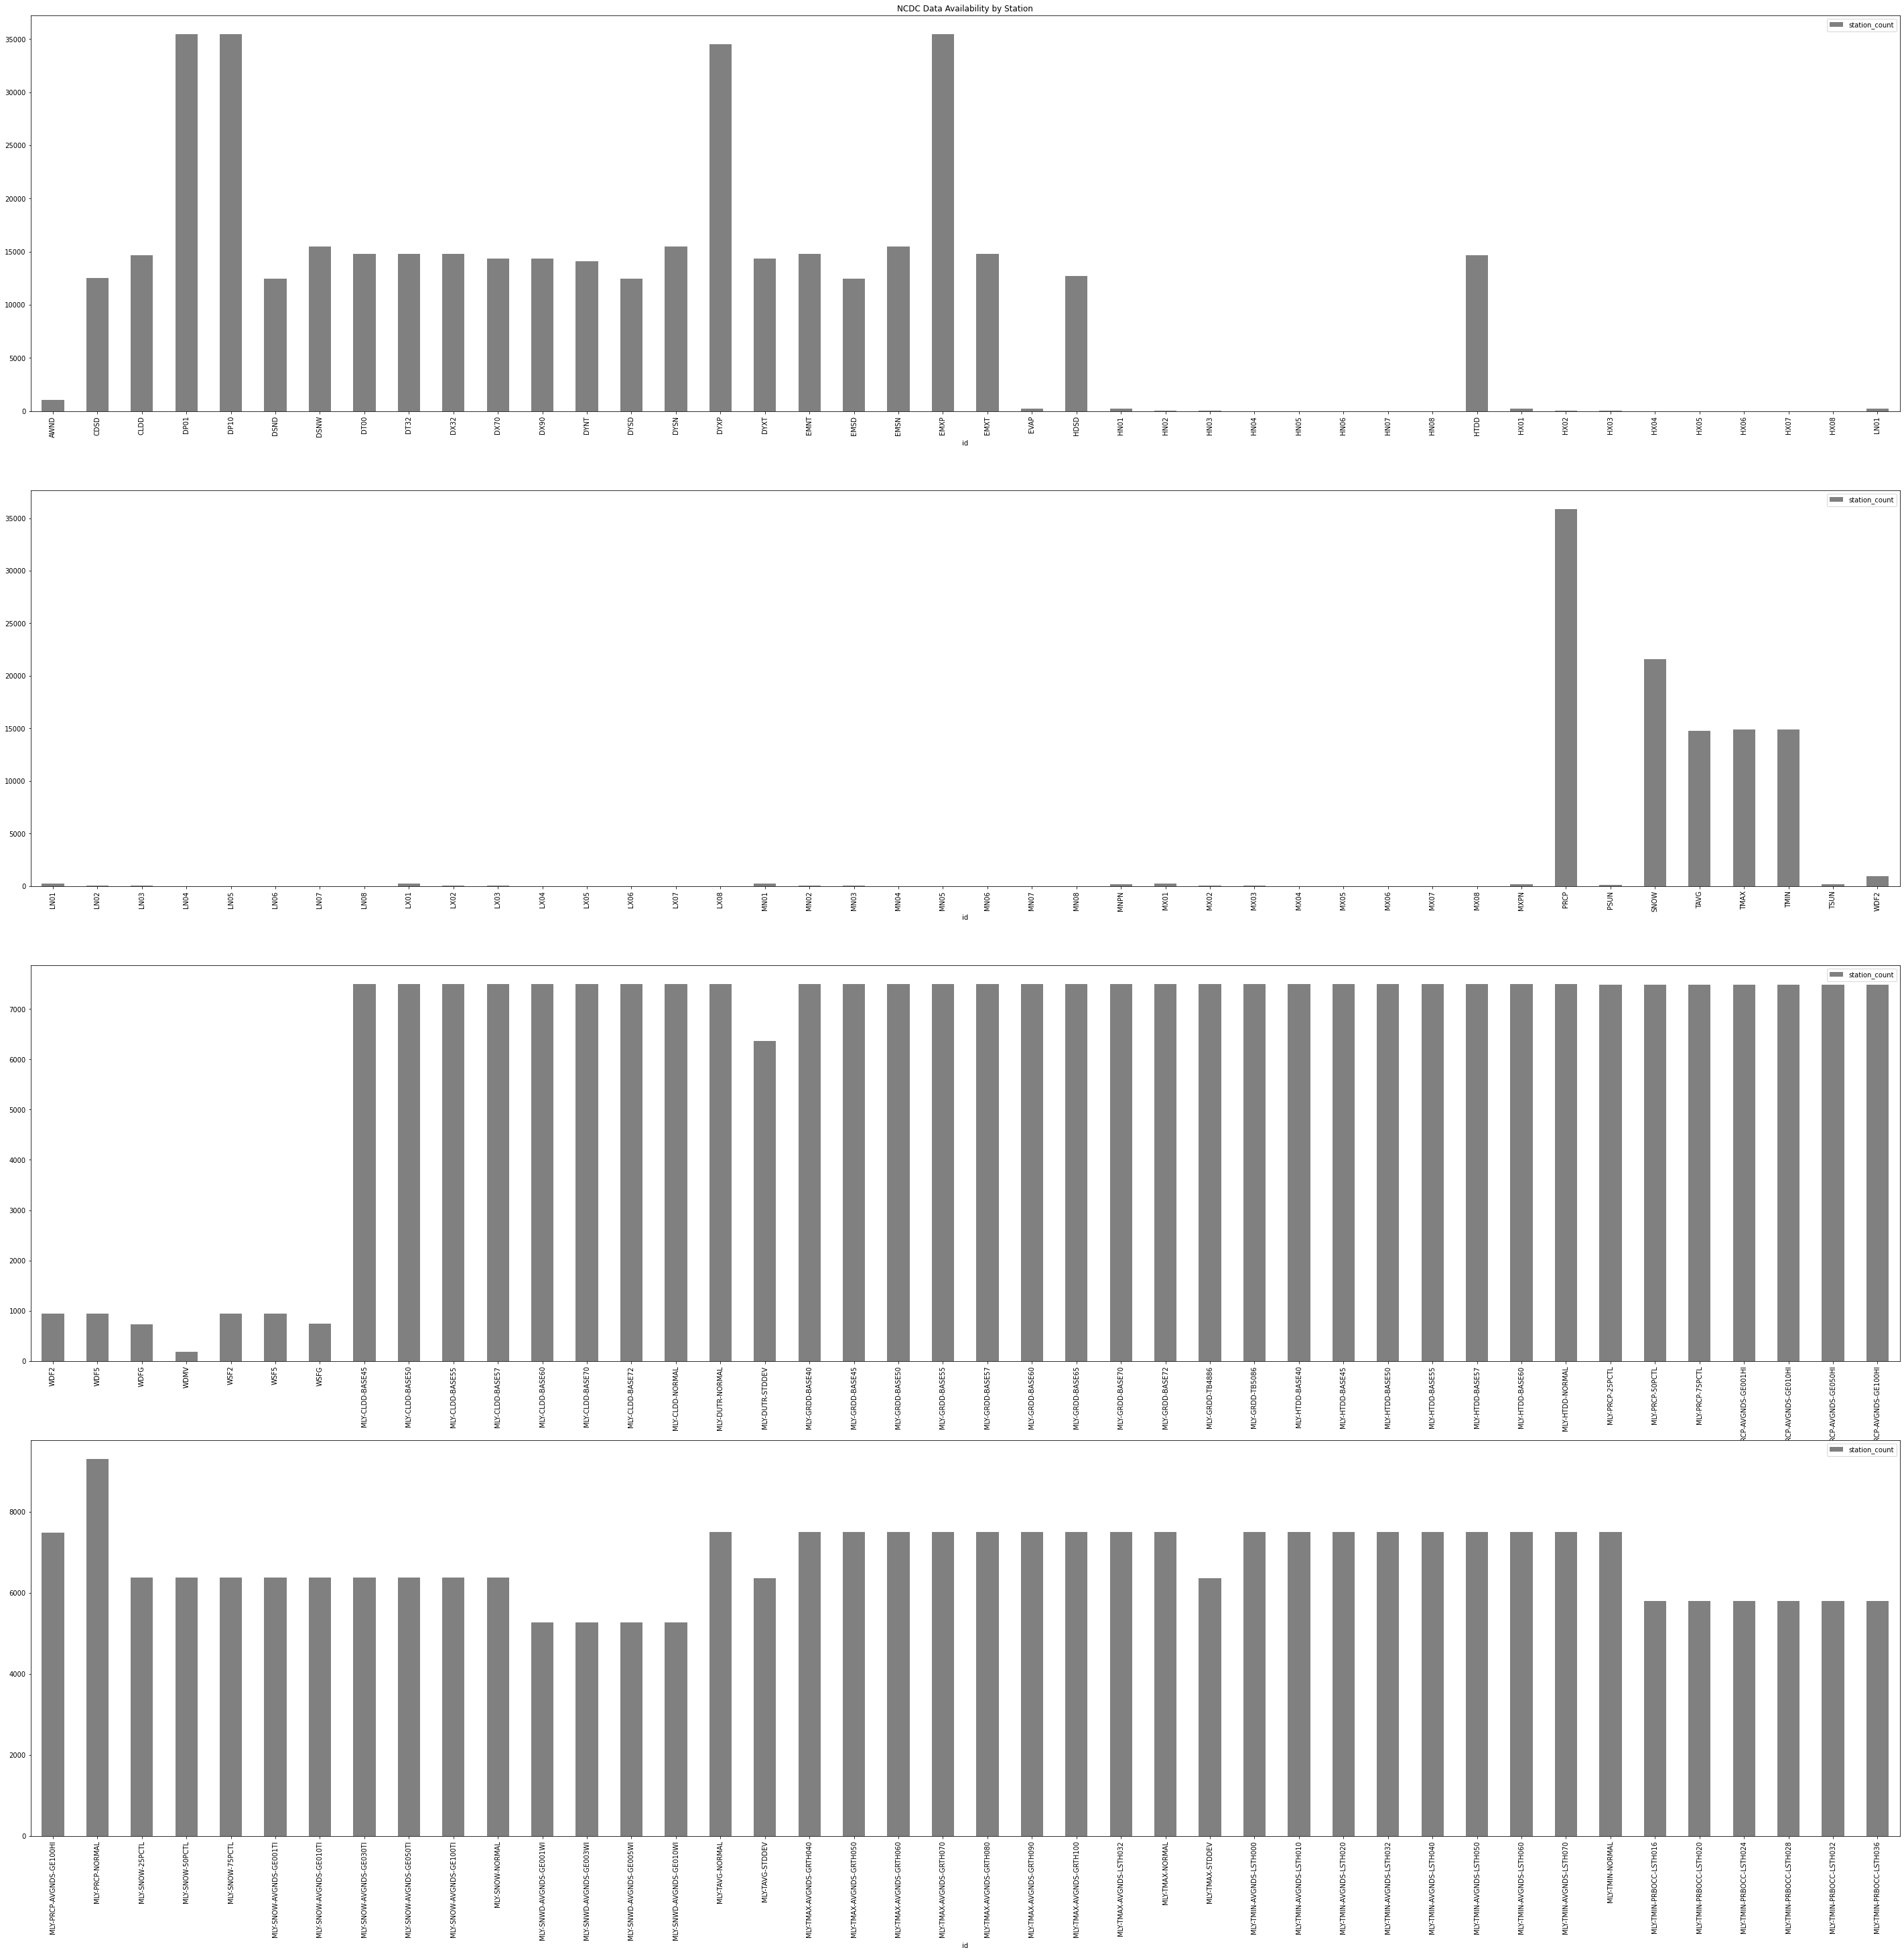

In [161]:
N = monthly_vars.shape[0]
fig, ax = plt.subplots(4, 1, figsize=(50, 50))
ax = ax.ravel()
for i in range(4):
    start, stop = N//4*i, N//4*(i+1)
    monthly_vars.loc[start:stop].plot(x="id", y="station_count", ax=ax[i], kind="bar", color="grey")
    ax[i].tick_params(axis='x', labelrotation=90)
ax[0].set_title("NCDC Data Availability by Station")
fig.savefig("data/ncdc_data_availability.png")

In [146]:
monthly_vars.to_csv("data/ncdc_datatypes.csv", index=False)

In [148]:
# consider only the variables available at >4000 stations
# this defines a natural cutoff over the monthly normals data,
# and will provide solid coverage over the US
predictors = monthly_vars[monthly_vars["station_count"] > 4000]
predictors = predictors.reset_index(drop=True)
predictors.to_csv("data/predictors.csv", index=False)
predictors

,dataset,id,mindate,maxdate,name,datacoverage,station_count
0,GSOM,CDSD,1763-01-01,2021-03-01,Cooling Degree Days Season to Date,1.0,12490
1,GSOM,CLDD,1763-01-01,2021-03-01,Cooling Degree Days,1.0,14687
2,GSOM,DP01,1781-01-01,2021-03-01,Number of days with greater than or equal to 0...,1.0,35454
3,GSOM,DP10,1781-01-01,2021-03-01,Number of days with greater than or equal to 1...,1.0,35454
4,GSOM,DSND,1860-01-01,2021-03-01,Number days with snow depth > 1 inch(25.4mm) f...,1.0,12427
...,...,...,...,...,...,...,...
100,NORMAL_MLY,MLY-TMIN-PRBOCC-LSTH024,2010-01-01,2010-12-01,probability of 24F or below at least once in t...,1.0,5805
101,NORMAL_MLY,MLY-TMIN-PRBOCC-LSTH028,2010-01-01,2010-12-01,probability of 28F or below at least once in t...,1.0,5805
102,NORMAL_MLY,MLY-TMIN-PRBOCC-LSTH032,2010-01-01,2010-12-01,probability of 32F or below at least once in t...,1.0,5805
103,NORMAL_MLY,MLY-TMIN-PRBOCC-LSTH036,2010-01-01,2010-12-01,probability of 36F or below at least once in t...,1.0,5805


In [194]:
gsom_predictors = predictors[predictors["dataset"] == "GSOM"].copy()
normal_predictors = predictors[predictors["dataset"] == "NORMAL_MLY"].copy()
gsom_predictors.shape, normal_predictors.shape

((28, 7), (77, 7))

## 3. Get Metadata of GSOM Stations with Complete Datasets

In [205]:
query = {
    "datasetid": "GSOM",
    "startdate": "2016-01-01",
    "enddate": "2016-12-31",
    "limit": "1000"
}
query_str = urllib.parse.urlencode(query, doseq=False)
ids = []
for i in list(gsom_predictors["id"].unique()):
    ids.append(f"&datatypeid={i}")
query_ids = "".join(ids)
endpoint = base_url + resource + query_str + query_ids
response = requests.get(endpoint, headers=headers)
print(response)
print(json.loads(response.text)["metadata"])

<Response [200]>
{'resultset': {'offset': 1, 'count': 4972, 'limit': 1000}}


In [206]:
n_stations = json.loads(response.text)["metadata"]["resultset"]["count"]
gsom_results = []
offset = 0

while offset < n_stations:
    query["offset"] = str(offset)
    query_str = urllib.parse.urlencode(query, doseq=False)
    endpoint = base_url + resource + query_str + query_ids
    response = requests.get(endpoint, headers=headers)
    gsom_results.extend(json.loads(response.text)["results"])
    print(f"Collected station information {offset}:{offset+1000}.")
    offset += 1000

Collected station information 0:1000.
Collected station information 1000:2000.
Collected station information 2000:3000.
Collected station information 3000:4000.
Collected station information 4000:5000.


In [221]:
gsom_stations = pd.DataFrame(gsom_results)
gsom_stations["dataset"] = "GSOM"
gsom_stations = gsom_stations[["name", "dataset"] + \
    [col for col in gsom_stations.columns if col not in ["name", "dataset"]]]
gsom_stations

,name,dataset,elevation,mindate,maxdate,latitude,datacoverage,id,elevationUnit,longitude
0,"CHEMAINUS, CA",GSOM,75.0,1919-01-01,2021-03-01,48.93330,0.8427,GHCND:CA001011500,METERS,-123.75000
1,"DUNCAN KELVIN CREEK, CA",GSOM,103.0,1987-04-01,2016-02-01,48.73330,0.9885,GHCND:CA001012573,METERS,-123.73330
2,"GALIANO NORTH, CA",GSOM,6.0,1975-02-01,2021-03-01,48.98330,0.8719,GHCND:CA0010130MN,METERS,-123.56670
3,"NORTH PENDER ISLAND, CA",GSOM,98.0,1972-03-01,2021-03-01,48.76670,0.7657,GHCND:CA001015638,METERS,-123.28330
4,"PORT RENFREW, CA",GSOM,10.0,1970-02-01,2021-03-01,48.60000,0.8388,GHCND:CA001016335,METERS,-124.33330
...,...,...,...,...,...,...,...,...,...,...
4968,"MARSHFIELD MUNICIPAL AIRPORT, WI US",GSOM,382.5,1996-07-01,2021-04-01,44.63806,0.9866,GHCND:USW00094985,METERS,-90.18750
4969,"SISSETON MUNICIPAL AIRPORT, SD US",GSOM,353.9,1998-09-01,2021-03-01,45.66889,1.0000,GHCND:USW00094993,METERS,-96.99139
4970,"BOSCOBEL AIRPORT, WI US",GSOM,204.8,1999-02-01,2021-04-01,43.15611,0.9963,GHCND:USW00094994,METERS,-90.67750
4971,"HENRY E. ROHLSEN AIRPORT, US",GSOM,18.6,1951-03-01,2021-03-01,17.69970,0.8561,GHCND:VQW00011624,METERS,-64.81250


In [222]:
gsom_stations.to_csv("data/ncdc_gsom_stations.csv", index=False)

## 4. Get Metadata of NORMAL_MLY Stations with Complete Datasets

In [209]:
query = {
    "datasetid": "NORMAL_MLY",
    "startdate": "2010-01-01",
    "enddate": "2010-12-31",
    "limit": "1000"
}
query_str = urllib.parse.urlencode(query, doseq=False)
ids = []
for i in list(normal_predictors["id"].unique()):
    ids.append(f"&datatypeid={i}")
query_ids = "".join(ids)
endpoint = base_url + resource + query_str + query_ids
response = requests.get(endpoint, headers=headers)
print(response)
print(json.loads(response.text)["metadata"])

<Response [200]>
{'resultset': {'offset': 1, 'count': 3638, 'limit': 1000}}


In [211]:
n_stations = json.loads(response.text)["metadata"]["resultset"]["count"]
normal_results = []
offset = 0

while offset < n_stations:
    query["offset"] = str(offset)
    query_str = urllib.parse.urlencode(query, doseq=False)
    endpoint = base_url + resource + query_str + query_ids
    response = requests.get(endpoint, headers=headers)
    normal_results.extend(json.loads(response.text)["results"])
    print(f"Collected station information {offset}:{offset+1000}.")
    offset += 1000

Collected station information 0:1000.
Collected station information 1000:2000.
Collected station information 2000:3000.
Collected station information 3000:4000.


In [223]:
normal_stations = pd.DataFrame(normal_results)
normal_stations["dataset"] = "NORMAL_MLY"
normal_stations = normal_stations[["name", "dataset"] + \
    [col for col in normal_stations.columns if col not in ["name", "dataset"]]]
normal_stations

,name,dataset,elevation,mindate,maxdate,latitude,datacoverage,id,elevationUnit,longitude
0,"PAGO PAGO WEATHER SERVICE OFFICE AIRPORT, US",NORMAL_MLY,3.7,2010-01-01,2010-12-01,-14.33056,1,GHCND:AQW00061705,METERS,-170.71361
1,"CAPITOL HILL 1, US",NORMAL_MLY,197.5,2010-01-01,2010-12-01,15.21553,1,GHCND:CQC00914080,METERS,145.75255
2,"ROTA AIRPORT, US",NORMAL_MLY,179.2,2010-01-01,2010-12-01,14.17170,1,GHCND:CQC00914801,METERS,145.24280
3,"YAP ISLAND WEATHER SERVICE OFFICE AIRPORT, FM",NORMAL_MLY,13.4,2010-01-01,2010-12-01,9.48333,1,GHCND:FMW00040308,METERS,138.08333
4,"GUAM INTERNATIONAL AIRPORT, US",NORMAL_MLY,77.4,2010-01-01,2010-12-01,13.48333,1,GHCND:GQW00041415,METERS,144.80000
...,...,...,...,...,...,...,...,...,...,...
3634,"OMAHA WSFO, NE US",NORMAL_MLY,399.0,2010-01-01,2010-12-01,41.36667,1,GHCND:USW00094918,METERS,-96.01667
3635,"HIBBING CHISHOLM HIBBING AIRPORT, MN US",NORMAL_MLY,412.1,2010-01-01,2010-12-01,47.38639,1,GHCND:USW00094931,METERS,-92.83889
3636,"PARK RAPIDS MUNICIPAL AIRPORT, MN US",NORMAL_MLY,437.1,2010-01-01,2010-12-01,46.90056,1,GHCND:USW00094967,METERS,-95.06778
3637,"CHRISTIANSTED FORT, US",NORMAL_MLY,9.1,2010-01-01,2010-12-01,17.74690,1,GHCND:VQC00671740,METERS,-64.70130


In [224]:
normal_stations.to_csv("data/ncdc_normal_mly_stations.csv", index=False)

## 5. Visualize Geographic Distribution of Stations

In [229]:
stations = pd.concat((gsom_stations, normal_stations)).reset_index(drop=True)
stations

,name,dataset,elevation,mindate,maxdate,latitude,datacoverage,id,elevationUnit,longitude
0,"CHEMAINUS, CA",GSOM,75.0,1919-01-01,2021-03-01,48.93330,0.8427,GHCND:CA001011500,METERS,-123.75000
1,"DUNCAN KELVIN CREEK, CA",GSOM,103.0,1987-04-01,2016-02-01,48.73330,0.9885,GHCND:CA001012573,METERS,-123.73330
2,"GALIANO NORTH, CA",GSOM,6.0,1975-02-01,2021-03-01,48.98330,0.8719,GHCND:CA0010130MN,METERS,-123.56670
3,"NORTH PENDER ISLAND, CA",GSOM,98.0,1972-03-01,2021-03-01,48.76670,0.7657,GHCND:CA001015638,METERS,-123.28330
4,"PORT RENFREW, CA",GSOM,10.0,1970-02-01,2021-03-01,48.60000,0.8388,GHCND:CA001016335,METERS,-124.33330
...,...,...,...,...,...,...,...,...,...,...
8607,"OMAHA WSFO, NE US",NORMAL_MLY,399.0,2010-01-01,2010-12-01,41.36667,1.0000,GHCND:USW00094918,METERS,-96.01667
8608,"HIBBING CHISHOLM HIBBING AIRPORT, MN US",NORMAL_MLY,412.1,2010-01-01,2010-12-01,47.38639,1.0000,GHCND:USW00094931,METERS,-92.83889
8609,"PARK RAPIDS MUNICIPAL AIRPORT, MN US",NORMAL_MLY,437.1,2010-01-01,2010-12-01,46.90056,1.0000,GHCND:USW00094967,METERS,-95.06778
8610,"CHRISTIANSTED FORT, US",NORMAL_MLY,9.1,2010-01-01,2010-12-01,17.74690,1.0000,GHCND:VQC00671740,METERS,-64.70130


In [238]:
gpd_stations = gpd.GeoDataFrame(stations[["dataset", "longitude", "latitude"]], crs="epsg:4326")
gpd_stations["geometry"] = [Point((long, lat)) for _, (_, long, lat) in gpd_stations.iterrows()]
gpd_stations

<ipython-input-238-d04e2757cb71>:1: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gpd_stations = gpd.GeoDataFrame(stations[["dataset", "longitude", "latitude"]], crs="epsg:4326")


,dataset,longitude,latitude,geometry
0,GSOM,-123.75000,48.93330,POINT (-123.75000 48.93330)
1,GSOM,-123.73330,48.73330,POINT (-123.73330 48.73330)
2,GSOM,-123.56670,48.98330,POINT (-123.56670 48.98330)
3,GSOM,-123.28330,48.76670,POINT (-123.28330 48.76670)
4,GSOM,-124.33330,48.60000,POINT (-124.33330 48.60000)
...,...,...,...,...
8607,NORMAL_MLY,-96.01667,41.36667,POINT (-96.01667 41.36667)
8608,NORMAL_MLY,-92.83889,47.38639,POINT (-92.83889 47.38639)
8609,NORMAL_MLY,-95.06778,46.90056,POINT (-95.06778 46.90056)
8610,NORMAL_MLY,-64.70130,17.74690,POINT (-64.70130 17.74690)


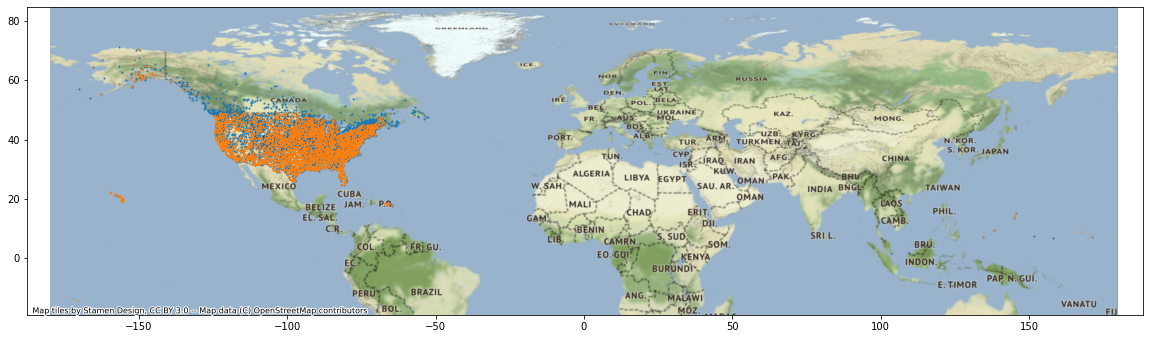

In [240]:
# plot data over whole world
colors = {"GSOM": plt.cm.tab10(0), "NORMAL_MLY": plt.cm.tab10(1)}
fig, ax = plt.subplots(figsize=(20, 20))
ax = gpd_stations[gpd_stations["dataset"] == "GSOM"].plot(ax=ax, markersize=1)
ax = gpd_stations[gpd_stations["dataset"] == "NORMAL_MLY"].plot(ax=ax, marker="+", markersize=1)
ctx.add_basemap(ax, crs=gpd_stations.crs)

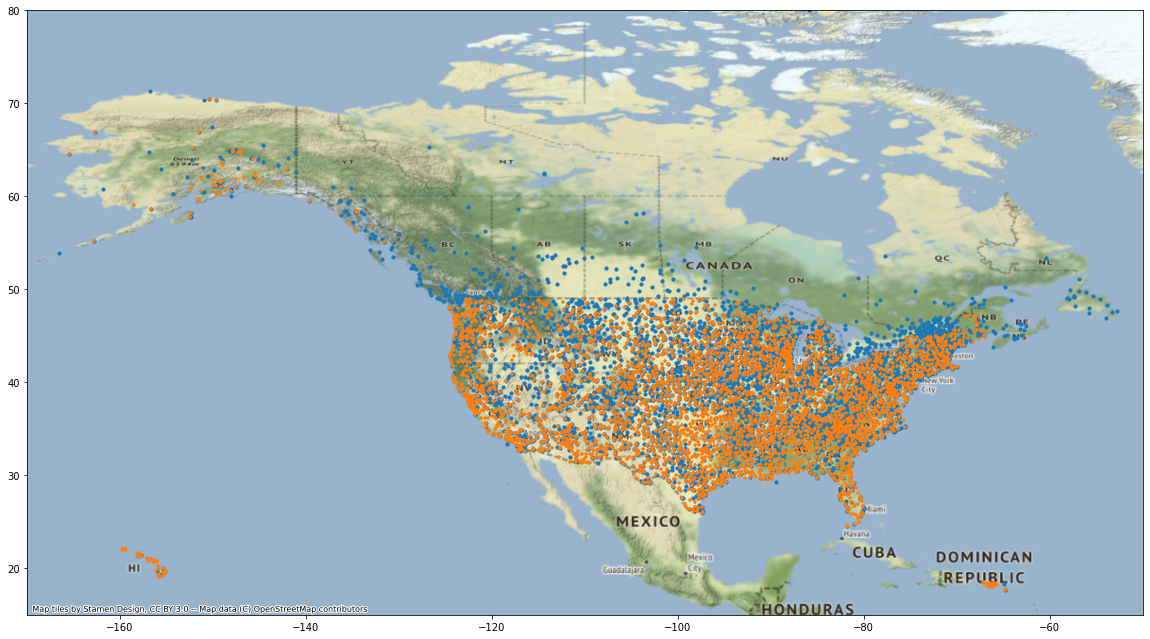

In [242]:
# plot north america only
fig, ax = plt.subplots(figsize=(20, 20))
ax = gpd_stations[gpd_stations["dataset"] == "GSOM"].plot(ax=ax, markersize=10)
ax = gpd_stations[gpd_stations["dataset"] == "NORMAL_MLY"].plot(ax=ax, marker="+", markersize=10)
ax.set_xlim((-170, -50))
ax.set_ylim((15, 80))
ctx.add_basemap(ax, crs=gpd_stations.crs)

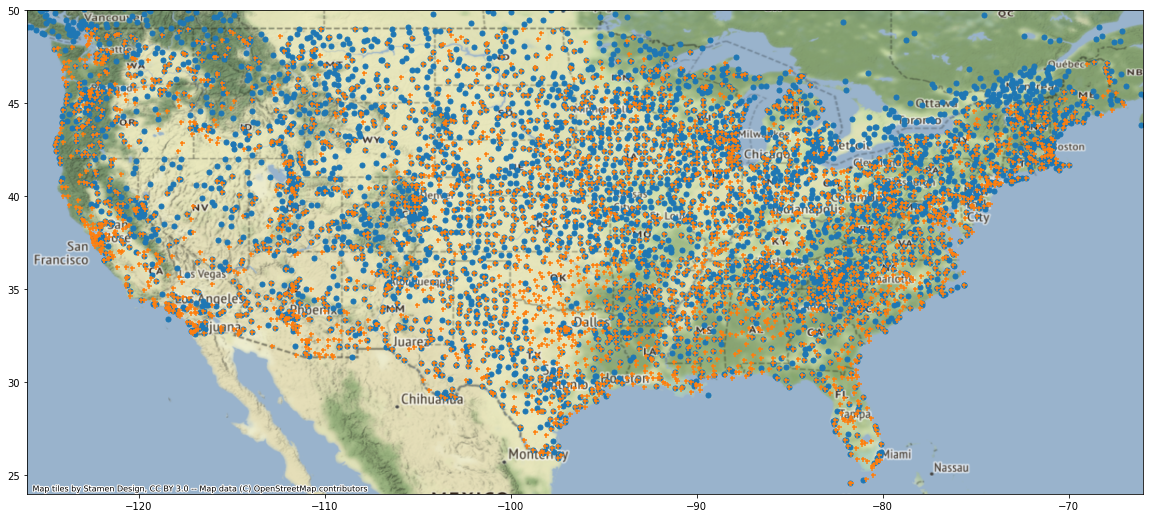

In [244]:
# plot CONUS only
fig, ax = plt.subplots(figsize=(20, 20))
ax = gpd_stations[gpd_stations["dataset"] == "GSOM"].plot(ax=ax, markersize=25)
ax = gpd_stations[gpd_stations["dataset"] == "NORMAL_MLY"].plot(ax=ax, marker="+", markersize=25)
ax.set_xlim((-126, -66))
ax.set_ylim((24, 50))
ctx.add_basemap(ax, crs=gpd_stations.crs)